/var/folders/mw/pbqq5xgj02jfqjprkzrsdxdh0000gn/T/ipykernel_9892/1842651491.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hd[categorical_cols] = hd[categorical_cols].fillna(hd[categorical_cols].mode().iloc[0])
/Users/rachel/Desktop/BINF/BINF5507/Labs/.pixi/envs/default/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e+06, tolerance: 8.256e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_c

R^2 score: 0.5994830889788603
RMSE: 69.16764780923744


/Users/rachel/Desktop/BINF/BINF5507/Labs/.pixi/envs/default/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e+04, tolerance: 8.256e+02
  model = cd_fast.enet_coordinate_descent(
/Users/rachel/Desktop/BINF/BINF5507/Labs/.pixi/envs/default/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.256e+04, tolerance: 8.256e+02
  model = cd_fast.enet_coordinate_descent(


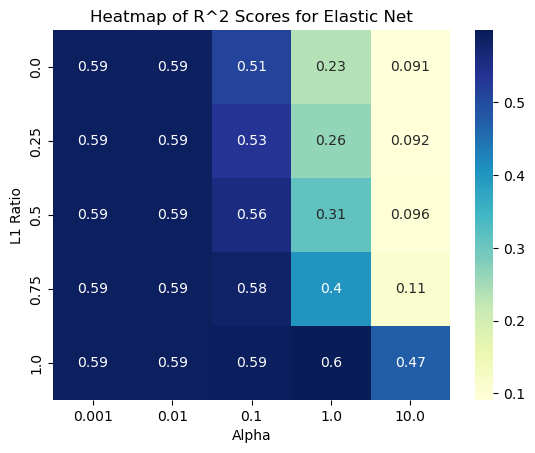

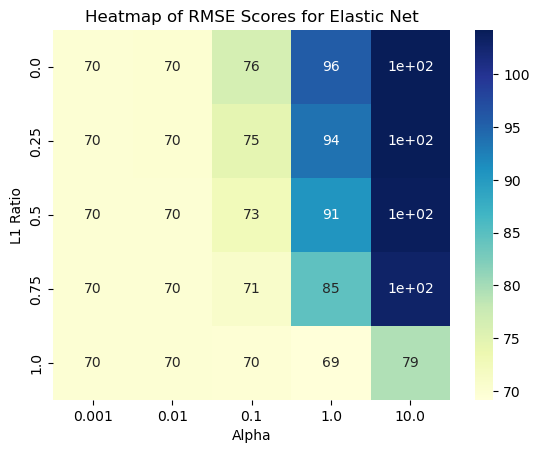

In [141]:
# Import necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
hd_messy = pd.read_csv('../Data/heart_disease_uci.csv')
hd = hd_messy.copy()

# Define numeric and catergorical columns
numeric_cols = hd.select_dtypes(include=['number']).columns
categorical_cols = hd.select_dtypes(include=['object']).columns

# Handle missing data 
hd = hd.dropna(subset=['chol']) # Remove columns with missing target values
hd[numeric_cols] = hd[numeric_cols].fillna(hd[numeric_cols].median())
hd[categorical_cols] = hd[categorical_cols].fillna(hd[categorical_cols].mode().iloc[0])
hd = hd.drop(columns=['ca', 'thal']) # too many missing values (>50%)

# Drop duplicates
hd = hd.drop_duplicates()

# Remove outliers
z_scores = np.abs(stats.zscore(hd[['age', 'trestbps', 'chol', 'thalch', 'oldpeak']]))
hd_no_out = hd[(z_scores < 3).all(axis=1)]

# Encode categorical features (one-hot)
hd_encoded = pd.get_dummies(hd_no_out, columns=['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope'])

# 1. Linear Regression
# Split data into training and testing sets 
X = hd_encoded.drop(columns=["chol"])
y = hd_encoded["chol"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model (elastic net)
elastic_net = ElasticNet(alpha=1.0, l1_ratio=1.0)
chol_model = elastic_net.fit(X_train, y_train)

# Predict on the test set
y_pred = chol_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
print("R^2 score:", r2)
print("RMSE:", RMSE)

# Define elastic net hyperparameter ranges
a_values = [0.001, 0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.0, 0.25, 0.5, 0.75, 1.0]

# Create empty matrices to store scores
r2_scores = np.zeros((len(a_values), len(l1_ratios)))
rmse_scores = np.zeros((len(a_values), len(l1_ratios)))

# Train models and store scores
for i, l1_ratio in enumerate(l1_ratios):
    for j, alpha in enumerate(a_values):
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2_scores[i, j] = r2_score(y_test, y_pred)
        rmse_scores[i, j] = np.sqrt(mean_squared_error(y_test, y_pred))
        
# Create dataframes for heatmaps
r2_df = pd.DataFrame(r2_scores, index=l1_ratios, columns=a_values)
rmse_df = pd.DataFrame(rmse_scores, index=l1_ratios, columns=a_values)
        
# R^2 Heatmap for visulization 
sns.heatmap(r2_df, annot=True, cmap='YlGnBu')
plt.xlabel('Alpha')
plt.ylabel('L1 Ratio')
plt.title('Heatmap of R^2 Scores for Elastic Net')
plt.show()

# RMSE Heatmap for visulization 
sns.heatmap(rmse_df, annot=True, cmap='YlGnBu')
plt.xlabel('Alpha')
plt.ylabel('L1 Ratio')
plt.title('Heatmap of RMSE Scores for Elastic Net')
plt.show()

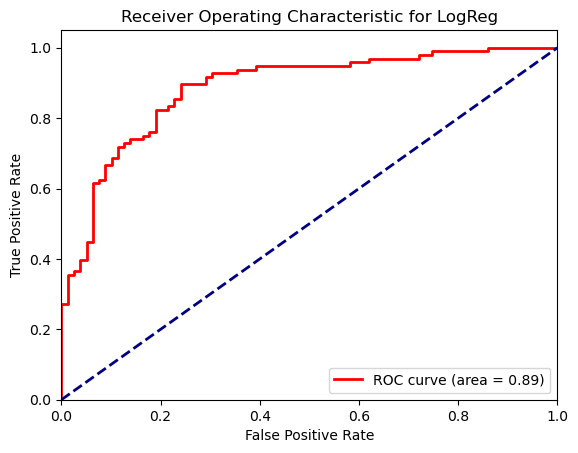

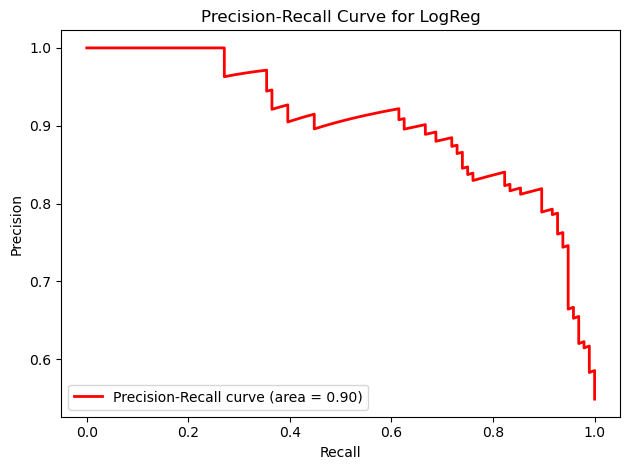

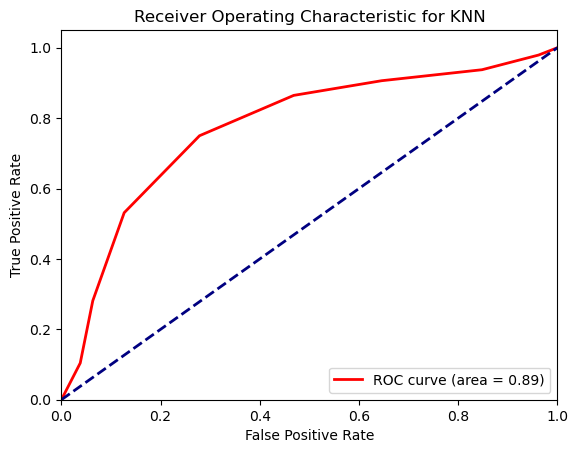

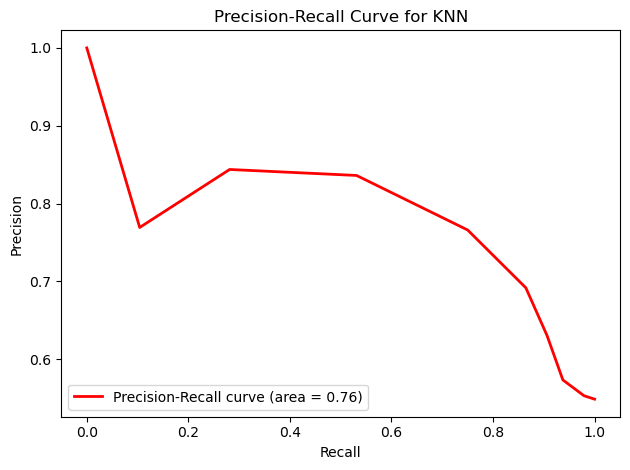

LogReg - Accuracy: 0.53, Precision: 0.54, Recall: 0.94 F1 Score: 0.68
k-NN - Accuracy: 0.74, Precision: 0.77, Recall: 0.75 F1 Score: 0.76


/Users/rachel/Desktop/BINF/BINF5507/Labs/.pixi/envs/default/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [164]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, precision_recall_curve, average_precision_score, f1_score, recall_score

# 2. Classification Models
# Logistic Regression

# Convert num column to binary outcome (0 = no heart disease, 1 = heart disease)
hd_encoded['num_binary'] = (hd_encoded['num'] > 0).astype(int)

# Split data into training and testing sets
X = hd_encoded.drop(columns=['num', 'num_binary'])
y = hd_encoded['num_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
logreg = LogisticRegression(C=9, penalty='l1', solver='liblinear', class_weight='balanced')
hd_lr_model = logreg.fit(X_train_scaled, y_train)

# Predict probabilities
y_scores = logreg.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and PR area
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LogReg')
plt.legend(loc='lower right')


# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LogReg')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# k-Nearest Neighbours

# Train a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

# Predict probabilities
y_scores_knn = knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scores_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores_knn)
average_precision = average_precision_score(y_test, y_scores_knn)

# Plot ROC curve
plt.figure()
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KNN')
plt.legend(loc='lower right')

# Plot Precisino-Recall Curve
plt.figure()
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for KNN')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# Evaluate the models
models = {'LogReg': logreg, 'k-NN': knn}
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f} F1 Score: {f1:.2f}")